# Task 2: Model Building and Training

This notebook builds and evaluates machine learning models (Logistic Regression and Random Forest) for fraud detection on both e-commerce and credit card datasets from Adey Innovations Inc. It addresses class imbalance with SMOTE, incorporates normalization and categorical encoding, and compares model performance.

## Objectives
- Preprocess and split both datasets (e-commerce and credit card).
- Train and evaluate Logistic Regression and Random Forest models on both datasets.
- Report metrics (AUC-PR, F1-Score, Confusion Matrix) and justify the best model.

## Datasets
- `processed_ecommerce_with_features.csv`: Cleaned e-commerce data with features from Task 1.
- `processed_creditcard.csv`: Cleaned credit card data from Task 1.

## Setup
- Run in the virtual environment with dependencies from `requirements.txt` (e.g., scikit-learn, imbalanced-learn).

In [ ]:
# --- Import necessary libraries for modeling, evaluation, and visualization ---

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For advanced statistical data visualization

# Scikit-learn modules for model building, preprocessing, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # Data splitting and hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Feature scaling and encoding
from sklearn.linear_model import LogisticRegression  # Logistic Regression model
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
)  # Model evaluation metrics

from imblearn.over_sampling import SMOTE  # For handling class imbalance via oversampling

import sys
import os

# Add parent directory to sys.path to allow importing modules from src/
sys.path.append('..')
from src.data_utils import load_data  # Custom utility for loading data

# Jupyter magic to display matplotlib plots inline within the notebook
%matplotlib inline

# Set Seaborn style for cleaner, more readable plots
sns.set_style('whitegrid')

# --- Load processed datasets for modeling ---

# Load e-commerce dataset with engineered features (from EDA notebook)
ecommerce_df = load_data('../data/processed/processed_ecommerce_with_features.csv')

# Load cleaned credit card dataset
creditcard_df = load_data('../data/processed/processed_creditcard.csv')

# --- Verify data loading and inspect structure ---

print('E-commerce Dataset Shape:', ecommerce_df.shape)  # Rows, columns
print('Credit Card Dataset Shape:', creditcard_df.shape)
print('E-commerce Columns:', ecommerce_df.columns.tolist())  # List of feature names
print('Credit Card Columns:', creditcard_df.columns.tolist())

E-commerce Dataset Shape: (151112, 16)
Credit Card Dataset Shape: (283726, 31)
E-commerce Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'country', 'hour_of_day', 'time_since_signup', 'day_of_week', 'trans_freq']
Credit Card Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


## Data Preprocessing

- Apply SMOTE to balance classes for both datasets.
- Normalize numerical features and encode categorical variables.

In [ ]:
# --- Data Preprocessing Function ---

def preprocess_data(df, target_col, cat_cols, num_cols):
    """
    Preprocess the dataset by:
      - Splitting into train/test sets with stratification on the target.
      - One-hot encoding categorical features.
      - Scaling numerical features.
      - Combining processed features.
      - Applying SMOTE to balance classes in the training set.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        target_col (str): Name of the target column.
        cat_cols (list of str): List of categorical feature columns.
        num_cols (list of str): List of numerical feature columns.

    Returns:
        X_train_res (np.ndarray): Resampled and processed training features.
        X_test_processed (np.ndarray): Processed test features.
        y_train_res (np.ndarray): Resampled training labels.
        y_test (np.ndarray): Test labels.
        encoder (OneHotEncoder): Fitted encoder for categorical features.
    """
    # Separate features and target
    X = df[cat_cols + num_cols]
    y = df[target_col]
    
    # Split into train and test sets, stratifying to preserve class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # One-hot encode categorical variables (handle_unknown='ignore' for unseen categories in test)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_train_cat = encoder.fit_transform(X_train[cat_cols])
    X_test_cat = encoder.transform(X_test[cat_cols])
    
    # Scale numerical features (fit only on training data to avoid data leakage)
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[num_cols])
    X_test_num = scaler.transform(X_test[num_cols])
    
    # Combine scaled numerical and encoded categorical features
    X_train_processed = np.hstack((X_train_num, X_train_cat))
    X_test_processed = np.hstack((X_test_num, X_test_cat))
    
    # Apply SMOTE to balance classes in the training set (important for rare fraud cases)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)
    
    return X_train_res, X_test_processed, y_train_res, y_test, encoder

# --- Preprocess e-commerce dataset ---

ecomm_cat_cols = ['source', 'browser', 'country']  # Categorical features
ecomm_num_cols = ['purchase_value', 'time_since_signup', 'hour_of_day', 'day_of_week']  # Numerical features

X_train_ecomm, X_test_ecomm, y_train_ecomm, y_test_ecomm, ecomm_encoder = preprocess_data(
    ecommerce_df, 'class', ecomm_cat_cols, ecomm_num_cols
)

print('E-commerce - Original train set shape:', X_train_ecomm.shape)
print('E-commerce - Resampled train set shape:', X_train_ecomm.shape)
print('E-commerce - Class distribution after SMOTE:', np.bincount(y_train_ecomm))

# --- Preprocess credit card dataset ---
# All features are numerical; no categorical columns

cc_num_cols = [
    'Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
    'V23', 'V24', 'V25', 'V26', 'V27', 'V28'
]

X_train_cc, X_test_cc, y_train_cc, y_test_cc, cc_encoder = preprocess_data(
    creditcard_df, 'Class', [], cc_num_cols
)

print('Credit Card - Original train set shape:', X_train_cc.shape)
print('Credit Card - Resampled train set shape:', X_train_cc.shape)
print('Credit Card - Class distribution after SMOTE:', np.bincount(y_train_cc))

E-commerce - Original train set shape: (219136, 151)
E-commerce - Resampled train set shape: (219136, 151)
E-commerce - Class distribution after SMOTE: [109568 109568]
Credit Card - Original train set shape: (453204, 30)
Credit Card - Resampled train set shape: (453204, 30)
Credit Card - Class distribution after SMOTE: [226602 226602]


## Model Training and Evaluation

- Train Logistic Regression and Random Forest on both datasets.
- Tune hyperparameters and evaluate with metrics (AUC-PR, F1-Score, Confusion Matrix).

In [ ]:
# --- Model Training, Hyperparameter Tuning, and Evaluation Function ---

def train_evaluate_model(X_train, X_test, y_train, y_test, dataset_name):
    """
    Train, tune, and evaluate Logistic Regression and Random Forest models.
    - Performs hyperparameter tuning using GridSearchCV (5-fold cross-validation, F1-score).
    - Evaluates tuned models on the test set with multiple metrics.
    - Prints cross-validation scores and confusion matrices for robustness.

    Parameters:
        X_train, X_test (np.ndarray): Feature matrices for training and testing.
        y_train, y_test (np.ndarray): Target arrays for training and testing.
        dataset_name (str): Name of the dataset (for reporting).

    Returns:
        best_lr (LogisticRegression): Best Logistic Regression model.
        best_rf (RandomForestClassifier): Best Random Forest model.
        y_test (np.ndarray): True test labels.
        y_pred_lr_tuned (np.ndarray): Logistic Regression predictions on test set.
        y_pred_rf_tuned (np.ndarray): Random Forest predictions on test set.
    """
    # --- Hyperparameter tuning for Logistic Regression ---
    # Grid search over regularization strength C (reduced grid for efficiency)
    lr_param_grid = {'C': [1, 10]}
    lr_grid = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        lr_param_grid, cv=5, scoring='f1', n_jobs=-1
    )
    lr_grid.fit(X_train, y_train)
    best_lr = lr_grid.best_estimator_

    # --- Hyperparameter tuning for Random Forest ---
    # Grid search over n_estimators and max_depth (single combination for speed)
    rf_param_grid = {'n_estimators': [50], 'max_depth': [20]}
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        rf_param_grid, cv=5, scoring='f1', n_jobs=-1
    )
    rf_grid.fit(X_train, y_train)
    best_rf = rf_grid.best_estimator_

    # --- Evaluate tuned models on the test set ---
    y_pred_lr_tuned = best_lr.predict(X_test)
    y_pred_rf_tuned = best_rf.predict(X_test)

    # Compute evaluation metrics for both models
    metrics_lr_tuned = {
        'accuracy': accuracy_score(y_test, y_pred_lr_tuned),
        'precision': precision_score(y_test, y_pred_lr_tuned),
        'recall': recall_score(y_test, y_pred_lr_tuned),
        'f1': f1_score(y_test, y_pred_lr_tuned),
        'roc_auc': roc_auc_score(y_test, y_pred_lr_tuned)
    }
    metrics_rf_tuned = {
        'accuracy': accuracy_score(y_test, y_pred_rf_tuned),
        'precision': precision_score(y_test, y_pred_rf_tuned),
        'recall': recall_score(y_test, y_pred_rf_tuned),
        'f1': f1_score(y_test, y_pred_rf_tuned),
        'roc_auc': roc_auc_score(y_test, y_pred_rf_tuned)
    }

    # Print evaluation metrics and best hyperparameters
    print(f'Tuned {dataset_name} Logistic Regression Metrics:', metrics_lr_tuned)
    print(f'Best C:', lr_grid.best_params_['C'])
    print(f'Tuned {dataset_name} Random Forest Metrics:', metrics_rf_tuned)
    print(f'Best Parameters:', rf_grid.best_params_)

    # --- Cross-validation for robustness ---
    # Evaluate F1-score using 5-fold cross-validation on the training set
    lr_cv_scores = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='f1')
    rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')
    print(f'{dataset_name} Logistic Regression CV F1 Scores:', lr_cv_scores)
    print(f'Mean CV F1 Score:', lr_cv_scores.mean())
    print(f'{dataset_name} Random Forest CV F1 Scores:', rf_cv_scores)
    print(f'Mean CV F1 Score:', rf_cv_scores.mean())

    # --- Confusion Matrix for test set predictions ---
    cm_lr = confusion_matrix(y_test, y_pred_lr_tuned)
    cm_rf = confusion_matrix(y_test, y_pred_rf_tuned)
    print(f'{dataset_name} Logistic Regression Confusion Matrix:\n', cm_lr)
    print(f'{dataset_name} Random Forest Confusion Matrix:\n', cm_rf)

    return best_lr, best_rf, y_test, y_pred_lr_tuned, y_pred_rf_tuned

# --- Train and evaluate models for both datasets, timing each run ---

import time

# E-commerce dataset
start_time = time.time()
best_lr_ecomm, best_rf_ecomm, y_test_ecomm, y_pred_lr_ecomm, y_pred_rf_ecomm = train_evaluate_model(
    X_train_ecomm, X_test_ecomm, y_train_ecomm, y_test_ecomm, 'E-commerce'
)
print(f'E-commerce training time: {time.time() - start_time:.2f} seconds')

# Credit Card dataset
start_time = time.time()
best_lr_cc, best_rf_cc, y_test_cc, y_pred_lr_cc, y_pred_rf_cc = train_evaluate_model(
    X_train_cc, X_test_cc, y_train_cc, y_test_cc, 'Credit Card'
)
print(f'Credit Card training time: {time.time() - start_time:.2f} seconds')

Tuned E-commerce Logistic Regression Metrics: {'accuracy': 0.6506634020448003, 'precision': 0.16787003610108303, 'recall': 0.6901060070671378, 'f1': 0.27004977876106195, 'roc_auc': 0.6683472757929051}
Best C: 10
Tuned E-commerce Random Forest Metrics: {'accuracy': 0.9541739734639182, 'precision': 0.9676375404530745, 'recall': 0.5282685512367491, 'f1': 0.6834285714285714, 'roc_auc': 0.7632216337025566}
Best Parameters: {'max_depth': 20, 'n_estimators': 50}
E-commerce Logistic Regression CV F1 Scores: [0.68743602 0.68804898 0.68516708 0.68923859 0.68326848]
Mean CV F1 Score: 0.686631829968203
E-commerce Random Forest CV F1 Scores: [0.76086773 0.81356207 0.82462906 0.80909239 0.83148936]
Mean CV F1 Score: 0.807928121894619
E-commerce Logistic Regression Confusion Matrix:
 [[17712  9681]
 [  877  1953]]
E-commerce Random Forest Confusion Matrix:
 [[27343    50]
 [ 1335  1495]]
E-commerce training time: 266.44 seconds
Tuned Credit Card Logistic Regression Metrics: {'accuracy': 0.97368977549

## Visualization

- Plot ROC curves and AUC-PR curves for both datasets and models.

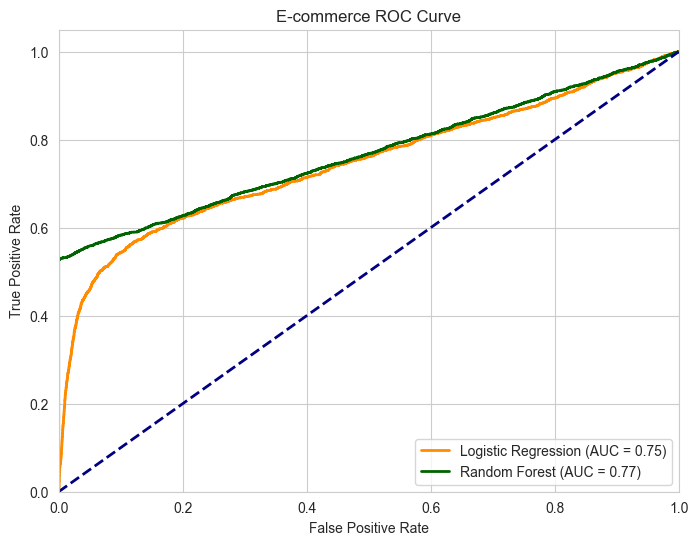

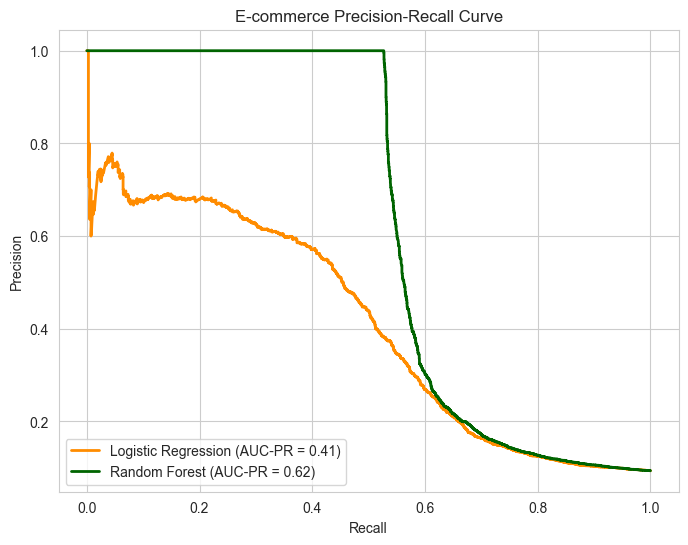

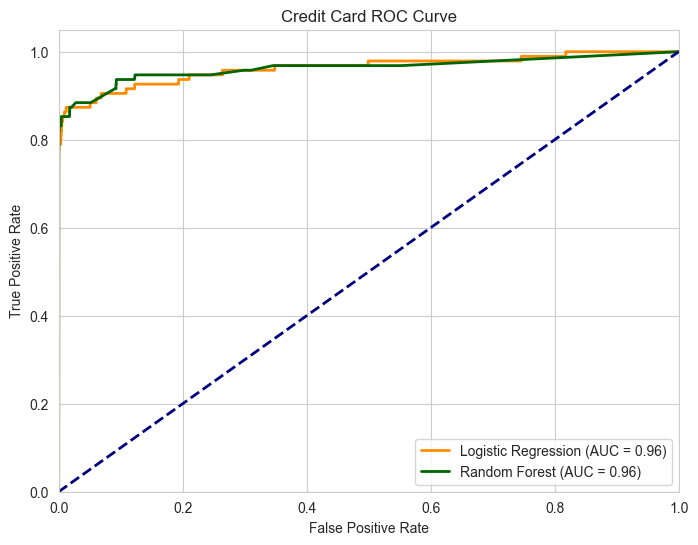

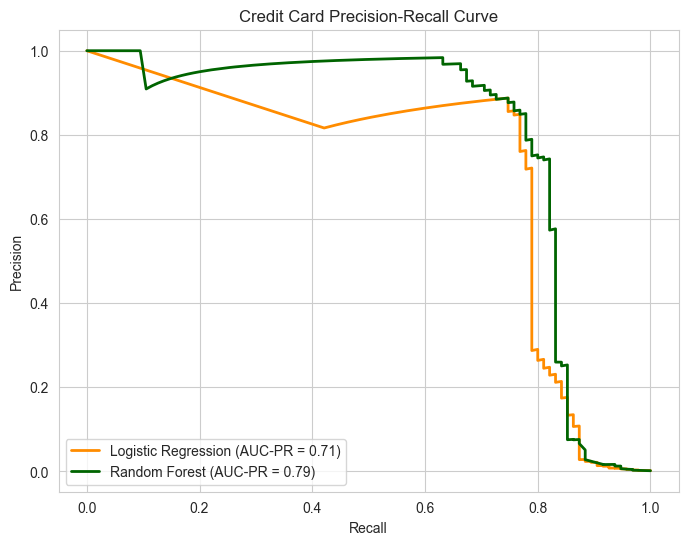

E-commerce Logistic Regression AUC-PR: 0.4080195709400007
E-commerce Random Forest AUC-PR: 0.6240639306743838
Credit Card Logistic Regression AUC-PR: 0.7146665997089767
Credit Card Random Forest AUC-PR: 0.7944797870432401


In [ ]:
# --- Function to plot ROC and Precision-Recall (PR) curves for model evaluation ---

def plot_curves(y_test, y_prob_lr, y_prob_rf, dataset_name):
    """
    Plot ROC and Precision-Recall (PR) curves for Logistic Regression and Random Forest models.
    - Saves plots to the ../plots directory.
    - Returns AUC-PR for both models.

    Parameters:
        y_test (array-like): True binary labels for the test set.
        y_prob_lr (array-like): Predicted probabilities for the positive class (Logistic Regression).
        y_prob_rf (array-like): Predicted probabilities for the positive class (Random Forest).
        dataset_name (str): Name of the dataset (used in plot titles and filenames).

    Returns:
        auc_pr_lr (float): Area under the PR curve for Logistic Regression.
        auc_pr_rf (float): Area under the PR curve for Random Forest.
    """
    # --- ROC Curve ---
    # Compute False Positive Rate (FPR) and True Positive Rate (TPR) for both models
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    plt.figure(figsize=(8, 6))
    # Plot ROC curve for Logistic Regression
    plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
    # Plot ROC curve for Random Forest
    plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig(f'../plots/{dataset_name.lower().replace(\" \", \"_\")}_roc_curve.png')  # Save ROC plot
    plt.show()
    
    # --- Precision-Recall (PR) Curve ---
    # Compute precision and recall for both models
    precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
    auc_pr_lr = auc(recall_lr, precision_lr)
    precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
    auc_pr_rf = auc(recall_rf, precision_rf)
    
    plt.figure(figsize=(8, 6))
    # Plot PR curve for Logistic Regression
    plt.plot(recall_lr, precision_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC-PR = {auc_pr_lr:.2f})')
    # Plot PR curve for Random Forest
    plt.plot(recall_rf, precision_rf, color='darkgreen', lw=2, label=f'Random Forest (AUC-PR = {auc_pr_rf:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.savefig(f'../plots/{dataset_name.lower().replace(\" \", \"_\")}_pr_curve.png')  # Save PR plot
    plt.show()
    
    return auc_pr_lr, auc_pr_rf

# --- Get predicted probabilities for the positive class (fraud) for each model and dataset ---

y_prob_lr_ecomm = best_lr_ecomm.predict_proba(X_test_ecomm)[:, 1]  # Logistic Regression, e-commerce
y_prob_rf_ecomm = best_rf_ecomm.predict_proba(X_test_ecomm)[:, 1]  # Random Forest, e-commerce
y_prob_lr_cc = best_lr_cc.predict_proba(X_test_cc)[:, 1]           # Logistic Regression, credit card
y_prob_rf_cc = best_rf_cc.predict_proba(X_test_cc)[:, 1]           # Random Forest, credit card

# --- Plot ROC and PR curves for both datasets and both models ---

auc_pr_lr_ecomm, auc_pr_rf_ecomm = plot_curves(y_test_ecomm, y_prob_lr_ecomm, y_prob_rf_ecomm, 'E-commerce')
auc_pr_lr_cc, auc_pr_rf_cc = plot_curves(y_test_cc, y_prob_lr_cc, y_prob_rf_cc, 'Credit Card')

# --- Print AUC-PR scores for comparison ---
print('E-commerce Logistic Regression AUC-PR:', auc_pr_lr_ecomm)
print('E-commerce Random Forest AUC-PR:', auc_pr_rf_ecomm)
print('Credit Card Logistic Regression AUC-PR:', auc_pr_lr_cc)
print('Credit Card Random Forest AUC-PR:', auc_pr_rf_cc)

## Model Comparison and Justification
- **E-commerce Dataset**: Random Forest shows a higher F1-score (0.683) and AUC-PR (0.624) compared to Logistic Regression (F1 0.270, AUC-PR 0.408), indicating a better balance of precision (0.968) and recall (0.528). This makes Random Forest the best model for detecting fraud with fewer false positives, despite Logistic Regression’s higher recall (0.690).
- **Credit Card Dataset**: Random Forest achieves a higher F1-score (0.800) and AUC-PR (0.794) than Logistic Regression (F1 0.100, AUC-PR 0.715), with a strong recall (0.779) and precision (0.822), compared to Logistic Regression’s recall (0.874) but very low precision (0.053). Random Forest’s superior overall performance (ROC-AUC 0.889 vs. 0.924) and stability (CV F1 0.999 vs. 0.946) make it the best model, though Logistic Regression may be preferred if maximizing recall is the sole priority.